<a href="https://colab.research.google.com/github/Jswirls/NFL_pbp_sim/blob/main/NFL_pbp_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nfl_data_py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 14.2 MB/s 
     |████████████████████████████████| 1.6 MB 34.3 MB/s 
     |████████████████████████████████| 140 kB 58.9 MB/s 


# Data Imports

In [ ]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
seasons = [2018,2019,2020]
pbp = nfl.import_pbp_data([2020])
rosters = nfl.import_depth_charts(seasons)
weekly_2020 = nfl.import_weekly_data([2020],columns=['week','season','player_id','recent_team','completions','attempts','passing_yards','passing_tds','sacks','carries',
                                                    'rushing_yards','rushing_tds','interceptions','sack_fumbles','rushing_fumbles','receptions','targets','receiving_tds',
                                                    'receiving_yards','receiving_fumbles'])
pbp_cols = ['game_id','home_team','away_team','season_type','week','posteam_type','yardline_100','game_date','half_seconds_remaining','game_seconds_remaining','down','goal_to_go','game_half',
            'ydstogo','play_type','yards_gained','shotgun','no_huddle','qb_dropback','qb_kneel','qb_spike','qb_scramble','pass_length','pass_location','air_yards','yards_after_catch',
            'run_location','run_gap','field_goal_result','kick_distance','extra_point_result','two_point_conv_result','home_timeouts_remaining','away_timeouts_remaining',
            'timeout','td_player_id','total_home_score','total_away_score','punt_blocked','incomplete_pass','interception','touchback','punt_fair_catch','fumble_forced','fumble_not_forced','rushing_yards',
            'safety','penalty','fumble_lost','qb_hit','sack','touchdown','return_touchdown','extra_point_attempt','two_point_attempt','field_goal_attempt','punt_attempt','fumble', 'wp',
            'passer_player_id','receiver_player_id','rusher_player_id','interception_player_id','punt_returner_player_id','kickoff_returner_player_id','punter_player_id','kicker_player_id',
            'tackle_for_loss_1_player_id','solo_tackle_1_player_id','assist_tackle_1_player_id','pass_defense_1_player_id','tackle_with_assist_1_player_id','fumbled_1_player_id','fumble_recovery_1_player_id',
            'sack_player_id','half_sack_1_player_id','half_sack_2_player_id','penalty_player_id','penalty_type','season','special_teams_play','spread_line','total_line','div_game','home_coach','away_coach', 'score_differential', 'out_of_bounds'
            ]
pbp = pbp[pbp_cols]

2020 done.
Downcasting floats.
Downcasting floats.


#PBP Data Manipulation

In [ ]:
pbp['play_category'] = None
pbp.loc[((pbp['down'] == 1) & (pbp['ydstogo'] == 10)),'play_category'] = '1_down'
pbp.loc[((pbp['down'] == 2) & (pbp['ydstogo'] < 3)),'play_category'] = '2_short'
pbp.loc[((pbp['down'] == 3) & (pbp['ydstogo'] < 3)),'play_category'] = '3/4_short'
pbp.loc[((pbp['down'] == 4) & (pbp['ydstogo'] < 3)),'play_category'] = '3/4_short'
pbp.loc[((pbp['down'] == 2) & (pbp['ydstogo'] < 7) & (pbp['ydstogo'] >= 3)),'play_category'] = '2_medium'
pbp.loc[((pbp['down'] == 3) & (pbp['ydstogo'] < 7) & (pbp['ydstogo'] >= 3)),'play_category'] = '3/4_medium'
pbp.loc[((pbp['down'] == 4) & (pbp['ydstogo'] < 7) & (pbp['ydstogo'] >= 3)),'play_category'] = '3/4_medium'
pbp.loc[((pbp['down'] == 2) & (pbp['ydstogo'] >= 7)) ,'play_category'] = '2_long'
pbp.loc[((pbp['down'] == 3) & (pbp['ydstogo'] >= 7)) ,'play_category'] = '3/4_long'
pbp.loc[((pbp['down'] == 4) & (pbp['ydstogo'] >= 7)) ,'play_category'] = '3/4_long'
pbp.loc[pbp['qb_scramble'] == 1, 'play_type'] = 'pass'

In [ ]:
pbp['pos_coach'] = pbp['home_coach']
pbp['pos_team'] = pbp['home_team']
pbp['def_team'] = pbp['away_team']
pbp.loc[(pbp['posteam_type']) == 'away','pos_coach'] = pbp['away_coach']
pbp.loc[(pbp['posteam_type']) == 'away','pos_team'] = pbp['away_team']
pbp.loc[(pbp['posteam_type']) == 'away','def_team'] = pbp['home_team']
pbp = pbp.merge(matchups_df, left_on=['pos_team','def_team'],right_index=True,how='left')
pbp = pbp.loc[pbp['penalty_type'].isna()]
pbp.loc[pbp['air_yards'] < 5, 'pass_length'] = 'short'
pbp.loc[(pbp['air_yards'] > 5) & (pbp['air_yards'] <= 15), 'pass_length'] = 'medium'
pbp.loc[pbp['air_yards'] > 15, 'pass_length'] = 'deep'
pbp.loc[((pbp['yardline_100'] <= 20) & (pbp['yardline_100'] > pbp['air_yards'])), 'pass_length'] = 'rz_short'
pbp.loc[((pbp['yardline_100'] <= 20) & (pbp['yardline_100'] <= pbp['air_yards'])), 'pass_length'] = 'rz_endzone'
pbp.loc[((pbp['yardline_100'] > 20) & (pbp['yardline_100'] <= pbp['air_yards'])), 'pass_length'] = 'long_endzone'
pbp.loc[((pbp['passer_player_id'].notna()) & (pbp['receiver_player_id'].isna())), 'pass_length'] = 'throw_away'
pbp.loc[pbp['sack'] == 1, 'pass_length'] = 'sack'
pbp.loc[pbp['qb_scramble'] == 1, 'pass_length'] = 'scramble'
pbp.loc[pbp['qb_scramble'] == 1, 'passer_player_id'] = pbp['rusher_player_id']
pbp.loc[pbp['qb_spike'] == 1, 'pass_length'] = 'spike'
pbp.loc[pbp['qb_kneel'] == 1, 'pass_length'] = 'kneel'
pbp.loc[pbp['qb_scramble'] == 1, 'rusher_player_id'] = None
passing_plays = pbp.loc[pbp['pass_length'].notna()]
non_passing = pbp.loc[pbp['pass_length'].isna()]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
rec_plays = passing_plays.loc[pbp['receiver_player_id'].notna()]
rec_plays.loc[rec_plays['pass_length'] == 'short', 'pass_length_rec'] = 'rec_short'
rec_plays.loc[rec_plays['pass_length'] == 'medium', 'pass_length_rec'] = 'rec_medium'
rec_plays.loc[rec_plays['pass_length'] == 'deep', 'pass_length_rec'] = 'rec_deep'
rec_plays.loc[rec_plays['pass_length'] == 'rz_short', 'pass_length_rec'] = 'rec_rz_short'
rec_plays.loc[rec_plays['pass_length'] == 'rz_endzone', 'pass_length_rec'] = 'rec_rz_endzone'
rec_plays.loc[rec_plays['pass_length'] == 'long_endzone', 'pass_length_rec'] = 'rec_long_endzone'
rushing_plays = non_passing.loc[non_passing['run_gap'].notna()]

#Not Currently used
fg_plays = non_passing.loc[non_passing['play_type'] == 'field_goal']
extra_point_plays = non_passing.loc[non_passing['play_type'] == 'extra_point']
kickoff_plays = non_passing.loc[non_passing['play_type'] == 'kickoff']
punt_plays = non_passing.loc[non_passing['play_type'] == 'punt']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
pbp

,game_id,home_team,away_team,season_type,week,posteam_type,yardline_100,game_date,half_seconds_remaining,game_seconds_remaining,...,pos_team,def_team,YPC,YPA,sack_rate,int_rate,sack_fumble_rate,rushing_fumble_rate,receiving_fumble_rate,neutral
0,2020_01_ARI_SF,SF,ARI,REG,1,None,NaN,2020-09-13,1800.0,3600.0,...,SF,ARI,4.511738,7.273010,0.082269,0.027095,0.244844,0.009156,0.005000,1
1,2020_01_ARI_SF,SF,ARI,REG,1,home,35.0,2020-09-13,1800.0,3600.0,...,SF,ARI,4.511738,7.273010,0.082269,0.027095,0.244844,0.009156,0.005000,1
3,2020_01_ARI_SF,SF,ARI,REG,1,home,55.0,2020-09-13,1782.0,3582.0,...,SF,ARI,4.511738,7.273010,0.082269,0.027095,0.244844,0.009156,0.005000,1
4,2020_01_ARI_SF,SF,ARI,REG,1,home,41.0,2020-09-13,1739.0,3539.0,...,SF,ARI,4.511738,7.273010,0.082269,0.027095,0.244844,0.009156,0.005000,1
5,2020_01_ARI_SF,SF,ARI,REG,1,home,39.0,2020-09-13,1701.0,3501.0,...,SF,ARI,4.511738,7.273010,0.082269,0.027095,0.244844,0.009156,0.005000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48509,2020_21_KC_TB,TB,KC,POST,21,away,10.0,2021-02-07,100.0,100.0,...,KC,TB,3.719828,7.387201,0.047867,0.019710,0.164857,0.006497,0.015457,0
48510,2020_21_KC_TB,TB,KC,POST,21,home,80.0,2021-02-07,93.0,93.0,...,TB,KC,4.299119,7.278366,0.030187,0.025438,0.034005,0.005304,0.022233,0
48511,2020_21_KC_TB,TB,KC,POST,21,home,81.0,2021-02-07,50.0,50.0,...,TB,KC,4.299119,7.278366,0.030187,0.025438,0.034005,0.005304,0.022233,0
48512,2020_21_KC_TB,TB,KC,POST,21,home,81.0,2021-02-07,30.0,30.0,...,TB,KC,4.299119,7.278366,0.030187,0.025438,0.034005,0.005304,0.022233,0


#Rosters

In [ ]:
rosters = rosters[['season','week','team','formation','position','depth_team','full_name','gsis_id']]
#Removes players listed twice, once for offense/defense and once for special teams
rosters = rosters.drop(rosters[(((rosters.position != 'K') & (rosters.position !=  'P')) & (rosters.formation == 'Special Teams'))].index)
rosters.drop_duplicates(inplace=True)
player_info = rosters[['gsis_id','position','full_name','formation']]
player_info.rename({'gsis_id' : 'player_id'}, inplace=True, axis=1)
player_info.drop_duplicates(inplace=True)
team_rosters_weekly = rosters.groupby(['team','season','week'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
team_rosters_weekly.get_group(('ARI',2018,1))

,season,week,team,formation,position,depth_team,full_name,gsis_id
24332,2018,1,ARI,Defense,FS,2,Tre Boston,00-0031261
24333,2018,1,ARI,Offense,TE,2,Gabe Holmes,00-0031884
24334,2018,1,ARI,Offense,TE,1,Ricky Seals-Jones,00-0033611
24335,2018,1,ARI,Defense,DE,2,Jacquies Smith,00-0029112
24336,2018,1,ARI,Offense,T,1,D.J. Humphries,00-0032222
24337,2018,1,ARI,Offense,G,2,Jeremy Vujnovich,00-0030629
24338,2018,1,ARI,Defense,OLB,2,Dennis Gardeck,00-0034473
24339,2018,1,ARI,Defense,OLB,1,Haason Reddick,00-0033875
24340,2018,1,ARI,Defense,DT,1,Robert Nkemdiche,00-0032761
24341,2018,1,ARI,Defense,CB,1,Jamar Taylor,00-0030484


#Pre-Play Decison Data and Models


## Coach Data Manipulation

In [ ]:
coaches = list(pbp['home_coach'].drop_duplicates())
pbp['neutral'] = 0
pbp.loc[(pbp['half_seconds_remaining'] > 180) & ((pbp['wp'] < .9) & (pbp['wp'] > .1)), 'neutral'] = 1
pass_run_only = pbp[(pbp['play_type'] == 'pass') | (pbp['play_type'] == 'run')]
neutral_plays = pass_run_only.loc[pbp['neutral'] == 1]

In [ ]:
#DATA NOT CURRENTLY USED, KEEPING FOR POSSIBLE USE FOR HAND MODEL
losing_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] > 180) & ((pass_run_only['wp'] < .1))]
winning_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] > 180) & ((pass_run_only['wp'] > .9))]
two_minute_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] < 180) & ((pass_run_only['wp'] < .9) & (pass_run_only['wp'] > .1))]
two_minute_losing_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] < 180) & (pass_run_only['wp'] < .1)]
two_minute_winning_plays = pass_run_only.loc[(pass_run_only['half_seconds_remaining'] < 180) & (pass_run_only['wp'] > .9)]

losing = losing_plays[['play_category','play_type']]
winning = winning_plays[['play_category','play_type']]
two_minute = two_minute_plays [['play_category','play_type']]
two_min_winning = two_minute_winning_plays[['play_category','play_type']]
two_min_losing =  two_minute_losing_plays[['play_category','play_type']]

In [ ]:
coach_data = neutral_plays[['pos_coach','play_category','play_type']].dropna()
coach_groups = coach_data.groupby(['pos_coach','play_category'])

coach_dict = {}
for i in coaches:
    coach_dict[i] = {'1_down':0,'2_short':0,'3/4_short':0,'2_medium':0,'3/4_medium':0,'2_long':0,'3/4_long':0}

for g in coach_groups.groups:
  if 'pass' in list(coach_groups.get_group(g)['play_type']):
    coach_dict[g[0]][g[1]] = coach_groups.get_group(g)['play_type'].value_counts()['pass']/coach_groups.get_group(g)['play_type'].count()    

coach_df = pd.DataFrame(coach_dict).transpose()
coach_df.loc['DEFAULT'] = coach_df.mean()
coach_dict = coach_df.transpose().to_dict()

In [ ]:
categories = ['1_down','2_short','3/4_short','2_medium','3/4_medium','2_long','3/4_long']
for i in coaches:
  for j in categories:
    pass_run_only.loc[(pass_run_only['play_category'] == j) & (pass_run_only['pos_coach'] == i), 'coach_neutral_pass_rate'] = coach_dict[i][j]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
pass_run_only[['pos_coach','play_category','coach_neutral_pass_rate']]

,pos_coach,play_category,coach_neutral_pass_rate
3,Kyle Shanahan,1_down,0.387597
4,Kyle Shanahan,1_down,0.387597
5,Kyle Shanahan,2_long,0.679389
6,Kyle Shanahan,3/4_long,0.864407
9,Kliff Kingsbury,1_down,0.478405
...,...,...,...
48504,Andy Reid,2_medium,0.589744
48505,Andy Reid,3/4_medium,0.978261
48506,Andy Reid,3/4_medium,0.978261
48508,Andy Reid,1_down,0.581197


##4th Down Decsion

In [ ]:
fourth_down_data = pbp.loc[(pbp['down'] == 4)][['play_type','pos_coach','yardline_100','half_seconds_remaining','game_seconds_remaining','ydstogo','score_differential']]
fourth_down_data.loc[(fourth_down_data['play_type'] == 'pass') | (fourth_down_data['play_type'] == 'run'), 'play_type'] = 'go_for_it'
fourth_down_data.dropna(inplace=True)
fourth_down_data = fourth_down_data.loc[(fourth_down_data['play_type'] != 'qb_kneel') & (fourth_down_data['play_type'] != 'no_play')]
fourth_down_data['play_type'].unique()

array(['field_goal', 'punt', 'go_for_it'], dtype=object)

In [ ]:
coach_fourth_down_data = fourth_down_data[['pos_coach','play_type']]
coach_fourth_down_groups = coach_fourth_down_data.groupby('pos_coach')
coach_fourth_down_dict = {}
for i in coaches:
    coach_fourth_down_dict[i] = {'go_for_it_rate' : 0}

for g in coach_fourth_down_groups.groups:
  if 'go_for_it' in list(coach_fourth_down_groups.get_group(g)['play_type']):
    coach_fourth_down_dict[g]['go_for_it_rate'] = coach_fourth_down_groups.get_group(g)['play_type'].value_counts()['go_for_it']/coach_fourth_down_groups.get_group(g)['play_type'].count()

coach_fourth_down_df = pd.DataFrame(coach_fourth_down_dict).transpose()
coach_fourth_down_df.loc['DEFAULT'] = coach_fourth_down_df.mean()
coach_fourth_down_dict = coach_fourth_down_df.transpose().to_dict()
fourth_down_data = fourth_down_data.merge(coach_fourth_down_df, left_on='pos_coach', right_index=True).drop('pos_coach',axis=1)

In [ ]:
dummies_fourth = pd.get_dummies(fourth_down_data[['play_type']])
dummies_fourth = pd.concat([dummies_fourth,fourth_down_data],axis=1)
dummies_fourth.corr()

,play_type_field_goal,play_type_go_for_it,play_type_punt,yardline_100,half_seconds_remaining,game_seconds_remaining,ydstogo,score_differential,go_for_it_rate
play_type_field_goal,1.000000,-0.299790,-0.648014,-0.669831,-0.078781,-0.013531,-0.009669,0.089379,-0.034956
play_type_go_for_it,-0.299790,1.000000,-0.532329,-0.203139,-0.173846,-0.229903,-0.297912,-0.210466,0.122562
play_type_punt,-0.648014,-0.532329,1.000000,0.756552,0.208696,0.195550,0.246417,0.088715,-0.066829
yardline_100,-0.669831,-0.203139,0.756552,1.000000,0.123596,0.085898,0.235600,-0.039385,-0.011834
half_seconds_remaining,-0.078781,-0.173846,0.208696,0.123596,1.000000,0.524597,-0.050354,0.023037,-0.021823
game_seconds_remaining,-0.013531,-0.229903,0.195550,0.085898,0.524597,1.000000,-0.032622,-0.008133,-0.036277
ydstogo,-0.009669,-0.297912,0.246417,0.235600,-0.050354,-0.032622,1.000000,-0.066629,0.023871
score_differential,0.089379,-0.210466,0.088715,-0.039385,0.023037,-0.008133,-0.066629,1.000000,-0.054174
go_for_it_rate,-0.034956,0.122562,-0.066829,-0.011834,-0.021823,-0.036277,0.023871,-0.054174,1.000000


In [ ]:
num_cols = ['yardline_100','half_seconds_remaining','game_seconds_remaining','ydstogo','score_differential','go_for_it_rate']
fourth_down_scaler = StandardScaler()
fourth_down_data[num_cols] = fourth_down_scaler.fit_transform(fourth_down_data[num_cols])
X = fourth_down_data.drop('play_type',axis=1)
y = fourth_down_data['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
fourth_down_clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train, y_train)
fourth_down_clf.score(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9101516919486581

In [ ]:
X_test_pred = fourth_down_clf.predict(X_test)
confusion_matrix(y_test,X_test_pred, labels=['field_goal','go_for_it','punt'])

array([[221,  16,   2],
       [ 25, 128,  19],
       [  4,  11, 431]])

Model appears to be under guessing cases field goals and go for it situations. Still pretty close, and a more conserivative model is probably better for simulation as it should hopefully avoid situations where it is unreasonable to go for it.

##Pass Run Model


###MLP Model

In [ ]:
pred_vars = pass_run_only[['play_type','yardline_100','half_seconds_remaining','game_seconds_remaining','down','goal_to_go','ydstogo','score_differential','coach_neutral_pass_rate']]
pred_vars['down']=pred_vars.down.astype('category')
dummies = pd.get_dummies(pred_vars['down'])
pred_vars = pd.concat([pred_vars,dummies],axis=1)
pred_vars.drop('down',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dummies = pd.get_dummies(pred_vars[['play_type']])
dummies = pd.concat([dummies,pred_vars],axis=1)
dummies.corr()

,play_type_pass,play_type_run,yardline_100,half_seconds_remaining,game_seconds_remaining,goal_to_go,ydstogo,score_differential,coach_neutral_pass_rate,1.0,2.0,3.0,4.0
play_type_pass,1.000000,-1.000000,0.051740,-0.087759,-0.043764,-0.058921,0.123450,-0.148312,0.362738,-0.171904,0.015514,0.193682,0.001956
play_type_run,-1.000000,1.000000,-0.051740,0.087759,0.043764,0.058921,-0.123450,0.148312,-0.362738,0.171904,-0.015514,-0.193682,-0.001956
yardline_100,0.051740,-0.051740,1.000000,0.116937,0.074912,-0.488586,0.254004,-0.016147,0.021795,0.068568,-0.007231,-0.031565,-0.072094
half_seconds_remaining,-0.087759,0.087759,0.116937,1.000000,0.509456,-0.035712,-0.003486,0.062294,-0.017335,0.024112,0.003246,-0.008279,-0.058398
game_seconds_remaining,-0.043764,0.043764,0.074912,0.509456,1.000000,-0.020555,-0.006056,0.063022,-0.013324,0.023858,0.008264,-0.004027,-0.072735
goal_to_go,-0.058921,0.058921,-0.488586,-0.035712,-0.020555,1.000000,-0.222952,-0.009041,-0.022401,0.016281,-0.013619,-0.008334,0.019490
ydstogo,0.123450,-0.123450,0.254004,-0.003486,-0.006056,-0.222952,1.000000,-0.003087,0.232424,0.344142,-0.132065,-0.197718,-0.154250
score_differential,-0.148312,0.148312,-0.016147,0.062294,0.063022,-0.009041,-0.003087,1.000000,0.023441,-0.008620,0.010808,0.018544,-0.053293
coach_neutral_pass_rate,0.362738,-0.362738,0.021795,-0.017335,-0.013324,-0.022401,0.232424,0.023441,1.000000,-0.476043,0.019789,0.551862,0.016102
1.0,-0.171904,0.171904,0.068568,0.024112,0.023858,0.016281,0.344142,-0.008620,-0.476043,1.000000,-0.633637,-0.446024,-0.128887


In [ ]:
num_cols = ['yardline_100','half_seconds_remaining','game_seconds_remaining','ydstogo','score_differential','coach_neutral_pass_rate']
pred_vars.dropna(inplace=True)

X = pred_vars.drop('play_type',axis=1)
y = pred_vars['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pass_run_scaler = StandardScaler()
X_train_scaled = pass_run_scaler.fit_transform(X_train)
pass_run_clf = MLPClassifier(random_state=42, max_iter=300).fit(X_train_scaled, y_train)
X_test_scaled = pass_run_scaler.transform(X_test)
pass_run_clf.score(X_test_scaled,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.7217033993276055

In [ ]:
X_test_pred = pass_run_clf.predict(X_test_scaled)
confusion_matrix(y_test,X_test_pred)

array([[4133,  906],
       [1329, 1663]])

In [ ]:
tests = pred_vars.drop('play_type',axis=1)
tests = tests.loc[382:383]
scaled_tests = pass_run_scaler.transform(tests)
pass_run_clf.predict(scaled_tests)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  FutureWarning,


array(['pass', 'pass'], dtype='<U4')

In [ ]:
tests.loc[382:383]

,yardline_100,half_seconds_remaining,game_seconds_remaining,goal_to_go,ydstogo,score_differential,coach_neutral_pass_rate,1.0,2.0,3.0,4.0
382,16.0,11.0,11.0,0.0,10.0,-4.0,0.618421,0,1,0,0
383,16.0,6.0,6.0,0.0,10.0,-4.0,1.000000,0,0,1,0


In [ ]:
pass_run_clf.predict_proba(scaled_tests)

array([[0.85895068, 0.14104932],
       [0.90549924, 0.09450076]])

Anytime it has a confidence of over .8 I'll guarentee a pass, seeings as test case 1 should also always be a pass in that situation given the game clock. Model could be imporved but will do for now.

In [ ]:
passing_vars = passing_plays[['pass_length','yardline_100','half_seconds_remaining','game_seconds_remaining','down','goal_to_go','ydstogo','score_differential','YPA']]
passing_vars['down']=passing_vars.down.astype('category')
passing_dummies = pd.get_dummies(passing_vars['down'])
passing_vars = pd.concat([passing_vars,passing_dummies],axis=1)
passing_vars.drop('down',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pass_vars = passing_vars.loc[(passing_vars['pass_length'] == 'short') | (passing_vars['pass_length'] == 'medium') | (passing_vars['pass_length'] == 'deep')]
rz_pass_vars = passing_vars.loc[(passing_vars['pass_length'] == 'rz_short') | (passing_vars['pass_length'] == 'rz_endzone')]

#Individual Player Data


In [ ]:
game_id_merge = pbp[['game_id','home_team','away_team','week','season']]
weekly_2020 = weekly_2020.merge(game_id_merge,how='left',on=['home_team','away_team','week','season']).drop_duplicates()
w_2020_games = weekly_2020.groupby('game_id')['targets']

In [ ]:
target_share = pd.Series()
carries_share = pd.Series()
w_2020_games = weekly_2020.groupby('game_id')
for game in w_2020_games.groups:
  temp_target_share = w_2020_games.get_group(game)['targets']/w_2020_games.get_group(game)['targets'].sum()
  temp_carries_share = w_2020_games.get_group(game)['carries']/w_2020_games.get_group(game)['carries'].sum()
  target_share = pd.concat([target_share,temp_target_share])
  carries_share = pd.concat([carries_share,temp_carries_share])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
weekly_2020 = weekly_2020.merge(target_share.rename('target_share'),how='left', left_index=True,right_index=True)
weekly_2020 = weekly_2020.merge(carries_share.rename('carries_share'),how='left', left_index=True,right_index=True)

In [ ]:
weekly_2020

,week,season,player_id,recent_team,completions,attempts,passing_yards,passing_tds,sacks,carries,...,receiving_fumbles,home_team,away_team,opp,game_id,target_share_x,carries_share_x,comp_per,target_share_y,carries_share_y
0,1,2020,00-0019596,TB,23,36,239.0,2,3.0,3,...,0.0,NO,TB,NO,2020_01_TB_NO,0.000000,0.050000,0.638889,0.000000,0.050000
176,2,2020,00-0019596,TB,23,35,217.0,1,0.0,1,...,0.0,TB,CAR,CAR,2020_02_CAR_TB,0.000000,0.021739,0.657143,0.000000,0.021739
341,3,2020,00-0019596,TB,25,38,297.0,3,2.0,5,...,0.0,DEN,TB,DEN,2020_03_TB_DEN,0.000000,0.128205,0.657895,0.000000,0.128205
502,4,2020,00-0019596,TB,30,46,369.0,5,0.0,3,...,0.0,TB,LAC,LAC,2020_04_LAC_TB,0.000000,0.060000,0.652174,0.000000,0.060000
663,5,2020,00-0019596,TB,25,41,253.0,1,3.0,3,...,0.0,CHI,TB,CHI,2020_05_TB_CHI,0.000000,0.088235,0.609756,0.000000,0.088235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921206,15,2020,00-0036450,TB,0,0,0.0,0,0.0,2,...,0.0,ATL,TB,ATL,2020_15_TB_ATL,0.010989,0.064516,NaN,0.010989,0.064516
921382,16,2020,00-0036450,TB,0,0,0.0,0,0.0,15,...,0.0,DET,TB,DET,2020_16_TB_DET,0.028169,0.365854,NaN,0.028169,0.365854
921541,18,2020,00-0036450,TB,0,0,0.0,0,0.0,5,...,0.0,WAS,TB,WAS,2020_18_TB_WAS,0.012658,0.096154,NaN,0.012658,0.096154
921726,16,2020,00-0036456,GB,0,0,0.0,0,0.0,0,...,0.0,GB,TEN,TEN,2020_16_TEN_GB,0.020408,0.000000,NaN,0.020408,0.000000


##Individual Player Data PBP

In [ ]:
passing_categories = ['short','medium','deep','rz_short','rz_endzone','long_endzone']
class Player:
  def __init__(self, player_id, pos, name):
    self.player_id = player_id
    self.pos = pos
    self.name = name
    self.games_order = []
    self.play_dists = {}
    self.current_dists = {}
    self.target_share = 0
    self.carries_share = 0
    self.max_air_yards = 0
    self.comp_pers = {}
    self.target_shares = {}
    
    
  #Adds play data for passing plays
  def add_pbp_passing_data(self, game, game_id):
    play_data = game.groupby('pass_length')
    play_types = play_data.groups
    current_game = {}
    for play in play_types:
      current_game[play] = play_data.get_group(play)[['game_id','air_yards','incomplete_pass','interception','sack','yardline_100','rushing_yards','fumble']].dropna(axis=1)
      if play not in self.play_dists.keys():
        self.play_dists[play] = current_game[play]
      else:
        self.play_dists[play] = pd.concat([self.play_dists[play],current_game[play]])
    self.current_dists = self.play_dists
    self.update_comp_per()
    self.games_order.append(game_id)

  #Adds play data for rushing plays
  def add_pbp_rushing_data(self, game, game_id):
    play_data = game.groupby('run_gap')
    play_types = play_data.groups
    current_game = {}
    for play in play_types:
      current_game[play] = play_data.get_group(play)[['game_id','rushing_yards','yardline_100','fumble']].dropna(axis=1)
      if play not in self.play_dists.keys():
        self.play_dists[play] = current_game[play]
      else:
        self.play_dists[play] = pd.concat([self.play_dists[play],current_game[play]])
    
    self.games_order.append(game_id)

  #Adds play data for recieving plays
  def add_pbp_recieving_data(self, game, game_id):
    play_data = game.groupby('pass_length_rec')
    play_types = play_data.groups
    current_game = {}
    for play in play_types:
      current_game[play] = play_data.get_group(play)[['game_id','air_yards','yards_after_catch','incomplete_pass','yardline_100','fumble']].dropna(axis=1)
      if play not in self.play_dists.keys():
        self.play_dists[play] = current_game[play]
      else:
        self.play_dists[play] = pd.concat([self.play_dists[play],current_game[play]])
    self.games_order.append(game_id)

  def get_prev_games_dist(self, game):
    if game in self.games_order:
      game_num = self.games_order.index(game)
      prev_games = self.games_order[max(0,game_num-16):game_num]
    else:
      prev_games = self.games_order[max(0,len(self.games_order)-16):len(self.games_order)]
    for key in self.play_dists.keys():
      self.current_dists[key] = self.play_dists[key].loc[self.play_dists[key]['game_id'].isin(prev_games)]
      if self.pos == 'QB':
        self.update_comp_per()
        
  def get_rand_from_dist(self, category):
       pass

  def update_comp_per(self):
    for key in self.play_dists.keys():
      if key in passing_categories:
        self.comp_pers[key] = len(self.play_dists[key].loc[self.play_dists[key]['incomplete_pass'] == 0])/len(self.play_dists[key])

  def calc_target_share(self, key, total_targets):
    self.target_shares['key'] = len(self.current_dists[key])/total_targets

  def calc_carries_share(self, key, total_carries):
    self.target_shares['key'] = len(self.current_dists[key])/total_carries


In [ ]:
players = {}
player_df = rosters.drop_duplicates(subset='gsis_id')
for index, row in player_df.iterrows():
  players[row['gsis_id']] = Player(row['gsis_id'],row['position'],row['full_name'])

In [ ]:
games = passing_plays.groupby('game_id')
for game in games.groups:
  game_group = games.get_group(game).groupby('passer_player_id')
  for ind_game in game_group.groups:
    if ind_game in players.keys():
      if players[ind_game].pos == 'QB':
        players[ind_game].add_pbp_passing_data(game_group.get_group(ind_game), game)

In [ ]:
games = rushing_plays.groupby('game_id')
for game in games.groups:
  game_group = games.get_group(game).groupby('rusher_player_id')
  for ind_game in game_group.groups:
    if ind_game in players.keys():
      if players[ind_game].pos == 'RB' or players[ind_game].pos == 'WR':
        players[ind_game].add_pbp_rushing_data(game_group.get_group(ind_game), game) 

In [ ]:
games = rec_plays.groupby('game_id')
for game in games.groups:
  game_group = games.get_group(game).groupby('receiver_player_id')
  for ind_game in game_group.groups:
    if ind_game in players.keys():
      if players[ind_game].pos == 'WR' or players[ind_game].pos == 'RB' or players[ind_game].pos == 'TE':
        players[ind_game].add_pbp_recieving_data(game_group.get_group(ind_game), game) 

In [ ]:
players['00-0026143'].name

'Matt Ryan'

In [ ]:
players['00-0026143'].comp_pers

{'deep': 0.6039603960396039,
 'long_endzone': 0.25,
 'medium': 0.7297297297297297,
 'rz_endzone': 0.38461538461538464,
 'rz_short': 0.723404255319149,
 'short': 0.7550200803212851}

In [ ]:
players['00-0026143'].current_dists['short']

,game_id,air_yards,incomplete_pass,interception,sack,yardline_100,fumble
2363,2020_01_SEA_ATL,-2.0,0.0,0.0,0.0,47.0,0.0
2366,2020_01_SEA_ATL,5.0,1.0,0.0,0.0,40.0,0.0
2390,2020_01_SEA_ATL,5.0,1.0,0.0,0.0,75.0,0.0
2392,2020_01_SEA_ATL,5.0,0.0,0.0,0.0,71.0,0.0
2393,2020_01_SEA_ATL,-3.0,1.0,0.0,0.0,60.0,0.0
...,...,...,...,...,...,...,...
43620,2020_17_ATL_TB,1.0,0.0,0.0,0.0,68.0,0.0
43623,2020_17_ATL_TB,0.0,0.0,0.0,0.0,43.0,0.0
43625,2020_17_ATL_TB,-2.0,0.0,0.0,0.0,43.0,0.0
43628,2020_17_ATL_TB,3.0,0.0,0.0,0.0,32.0,1.0


#Distrabutions

##Air Yards Distrabutions

In [ ]:
short_passes = rec_plays.loc[rec_plays['pass_length_rec'] == 'rec_short']
med_passes = rec_plays.loc[rec_plays['pass_length_rec'] == 'rec_medium']
deep_passes = rec_plays.loc[rec_plays['pass_length_rec'] == 'rec_deep']
rz_passes = rec_plays.loc[rec_plays['pass_length_rec'] == 'rec_rz_short']

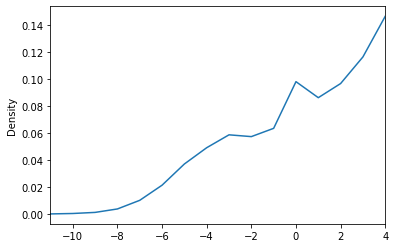

In [ ]:
short_dist = short_passes['air_yards'].plot.density(xlim=(int(short_passes['air_yards'].min()),int(short_passes['air_yards'].max()-1)), ind=range(int(short_passes['air_yards'].min()),int(short_passes['air_yards'].max()))).get_lines()[0].get_xydata()

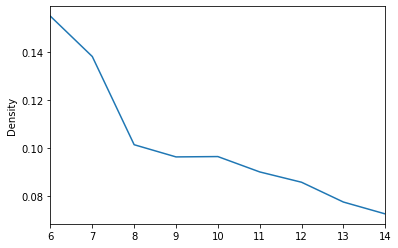

In [ ]:
med_dist = med_passes['air_yards'].plot.density(xlim=(int(med_passes['air_yards'].min()),int(med_passes['air_yards'].max()-1)), ind=range(int(med_passes['air_yards'].min()),int(med_passes['air_yards'].max()))).get_lines()[0].get_xydata()

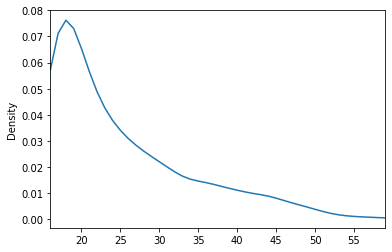

In [ ]:
deep_dist = deep_passes['air_yards'].plot.density(xlim=(int(deep_passes['air_yards'].min()),int(deep_passes['air_yards'].max()-1)), ind=range(int(deep_passes['air_yards'].min()),int(deep_passes['air_yards'].max()))).get_lines()[0].get_xydata()

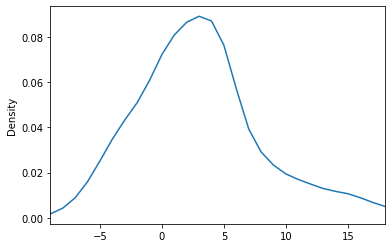

In [ ]:
rz_dist = rz_passes['air_yards'].plot.density(xlim=(int(rz_passes['air_yards'].min()),int(rz_passes['air_yards'].max()-1)), ind=range(int(rz_passes['air_yards'].min()),int(rz_passes['air_yards'].max()))).get_lines()[0].get_xydata()

In [ ]:
def fix_dist(pd_dist, column):
  fix = (1 - pd_dist[column].sum())/pd_dist[column].count()
  pd_dist[column] = pd_dist[column] + fix

In [ ]:
short_df = pd.DataFrame(short_dist)
med_df = pd.DataFrame(med_dist)
deep_df = pd.DataFrame(deep_dist)
rz_df = pd.DataFrame(rz_dist)
fix_dist(short_df, 1)
fix_dist(med_df, 1)
fix_dist(deep_df, 1)
fix_dist(rz_df, 1)

In [ ]:
np.random.choice(rz_dist[:,0],p=rz_dist[:,1])

0.0

#YAC Distrabutions

In [ ]:
catches = rec_plays.loc[(rec_plays['incomplete_pass']==0) & (rec_plays['interception']==0)]
catches['yards_after_catch'] = catches['yards_after_catch'].fillna(0)
catches.pass_length.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array(['medium', 'short', 'rz_short', 'deep', 'rz_endzone',
       'long_endzone'], dtype=object)

In [ ]:
short_passes_yac = catches.loc[catches['pass_length_rec'] == 'rec_short']
med_passes_yac = catches.loc[catches['pass_length_rec'] == 'rec_medium']
deep_passes_yac = catches.loc[catches['pass_length_rec'] == 'rec_deep']
rz_passes_yac = catches.loc[catches['pass_length_rec'] == 'rec_rz_short']

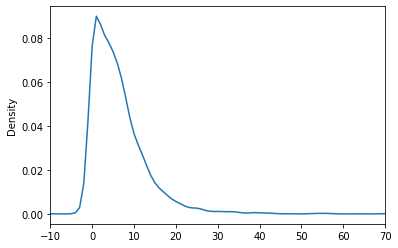

In [ ]:
short_dist_yac = short_passes_yac['yards_after_catch'].plot.density(xlim=(int(short_passes_yac['yards_after_catch'].min()),int(short_passes_yac['yards_after_catch'].max()-1)), ind=range(int(short_passes_yac['yards_after_catch'].min()),int(short_passes_yac['yards_after_catch'].max()))).get_lines()[0].get_xydata()

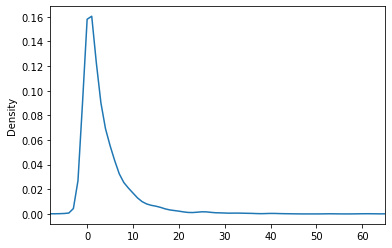

In [ ]:
med_dist_yac = med_passes_yac['yards_after_catch'].plot.density(xlim=(int(med_passes_yac['yards_after_catch'].min()),int(med_passes_yac['yards_after_catch'].max()-1)), ind=range(int(med_passes_yac['yards_after_catch'].min()),int(med_passes_yac['yards_after_catch'].max()))).get_lines()[0].get_xydata()

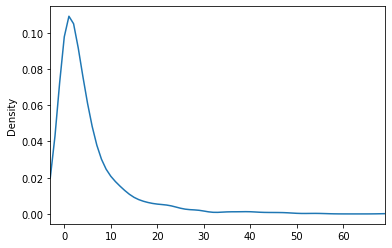

In [ ]:
deep_dist_yac = deep_passes_yac['yards_after_catch'].plot.density(xlim=(int(deep_passes_yac['yards_after_catch'].min()),int(deep_passes_yac['yards_after_catch'].max()-1)), ind=range(int(deep_passes_yac['yards_after_catch'].min()),int(deep_passes_yac['yards_after_catch'].max()))).get_lines()[0].get_xydata()

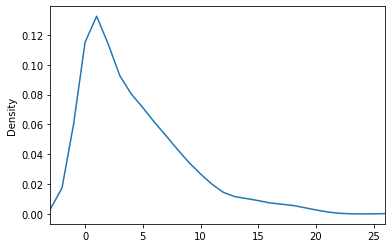

In [ ]:
rz_dist_yac = rz_passes_yac['yards_after_catch'].plot.density(xlim=(int(rz_passes_yac['yards_after_catch'].min()),int(rz_passes_yac['yards_after_catch'].max()-1)), ind=range(int(rz_passes_yac['yards_after_catch'].min()),int(rz_passes_yac['yards_after_catch'].max()))).get_lines()[0].get_xydata()

In [ ]:
short_yac_df = pd.DataFrame(short_dist_yac)
med_yac_df = pd.DataFrame(med_dist_yac)
deep_yac_df = pd.DataFrame(deep_dist_yac)
rz_yac_df = pd.DataFrame(rz_dist_yac)
fix_dist(short_yac_df, 1)
fix_dist(med_yac_df, 1)
fix_dist(deep_yac_df, 1)
fix_dist(rz_yac_df, 1)

In [ ]:
np.random.choice(short_dist_yac[:,0],p=short_dist_yac[:,1])

3.0

##Run Distrabutions

In [ ]:
guard_runs = rushing_plays.loc[rushing_plays['run_gap'] == 'guard']
tackle_runs = rushing_plays.loc[rushing_plays['run_gap'] == 'tackle']
end_runs = rushing_plays.loc[rushing_plays['run_gap'] == 'end']

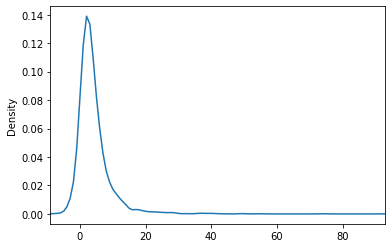

In [ ]:
guard_dist = guard_runs['yards_gained'].plot.density(xlim=(int(guard_runs['yards_gained'].min()),int(guard_runs['yards_gained'].max()-1)), ind=range(int(guard_runs['yards_gained'].min()),int(guard_runs['yards_gained'].max()))).get_lines()[0].get_xydata()

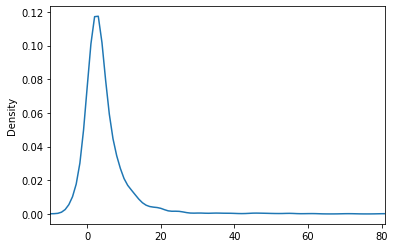

In [ ]:
tackle_dist = tackle_runs['yards_gained'].plot.density(xlim=(int(tackle_runs['yards_gained'].min()),int(tackle_runs['yards_gained'].max()-1)), ind=range(int(tackle_runs['yards_gained'].min()),int(tackle_runs['yards_gained'].max()))).get_lines()[0].get_xydata()

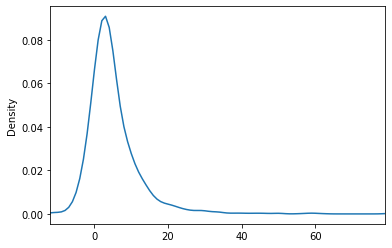

In [ ]:
end_dist = end_runs['yards_gained'].plot.density(xlim=(int(end_runs['yards_gained'].min()),int(end_runs['yards_gained'].max()-1)), ind=range(int(end_runs['yards_gained'].min()),int(end_runs['yards_gained'].max()))).get_lines()[0].get_xydata()

In [ ]:
guard_df = pd.DataFrame(guard_dist)
tackle_df = pd.DataFrame(tackle_dist)
end_df = pd.DataFrame(end_dist)
fix_dist(guard_df, 1)
fix_dist(tackle_df, 1)
fix_dist(end_df, 1)

In [ ]:
np.random.choice(tackle_dist[:,0],p=tackle_dist[:,1])

4.0

#PBP Model

['yardline_100','half_seconds_remaining','game_seconds_remaining','ydstogo','score_differential','coach_neutral_pass_rate'] Needed for P/R

In [ ]:
team_rosters_weekly.get_group(('ARI',2018,1))

,season,week,team,formation,position,depth_team,full_name,gsis_id
24332,2018,1,ARI,Defense,FS,2,Tre Boston,00-0031261
24333,2018,1,ARI,Offense,TE,2,Gabe Holmes,00-0031884
24334,2018,1,ARI,Offense,TE,1,Ricky Seals-Jones,00-0033611
24335,2018,1,ARI,Defense,DE,2,Jacquies Smith,00-0029112
24336,2018,1,ARI,Offense,T,1,D.J. Humphries,00-0032222
24337,2018,1,ARI,Offense,G,2,Jeremy Vujnovich,00-0030629
24338,2018,1,ARI,Defense,OLB,2,Dennis Gardeck,00-0034473
24339,2018,1,ARI,Defense,OLB,1,Haason Reddick,00-0033875
24340,2018,1,ARI,Defense,DT,1,Robert Nkemdiche,00-0032761
24341,2018,1,ARI,Defense,CB,1,Jamar Taylor,00-0030484


In [ ]:
h = team_rosters_weekly.get_group(('ARI',2018,1))[['position','depth_team','full_name','gsis_id','formation']]
list(h.loc[(h['position'] == 'QB') & (h['depth_team'] == 1),'gsis_id'])[0]

'00-0027854'

In [ ]:
class PBP_Sim:
  def __init__(self, home_team, away_team, home_coach='DEFAULT', away_coach='DEFAULT', week=1, season=2020, neutral = False):

    #General Game data
    self.home_team = home_team
    self.away_team = away_team
    self.week = week
    self.season = season
    self.starting_ko_team = self.pos_team
    self.home_score = 0
    self.away_score = 0
    self.score_diff = 0
    self.max_air_yards = 0
    self.game_seconds_remaining = 3600
    self.half_seconds_remaining = 1800
    self.quarter_seconds_remaining = 900
    self.down = None
    self.ydstogo = None
    self.yardline = None
    self.home_to = 3
    self.away_to = 3
    self.play_log = []
    self.play = {}

    #Randomize starting team (inital pos team kicks off so pos team decided here actually starts defending)
    self.pos_team = np.random.choice([home_team,away_team],size=1)
    if self.pos_team == home_team:
      self.def_team = away_team
    else:
      self.def_team = home_team

    #Roster Data
    self.home_roster = team_rosters_weekly.get_group((home_team,season,week))[['position','depth_team','full_name','gsis_id']]
    self.away_roster = team_rosters_weekly.get_group((away_team,season,week))[['position','depth_team','full_name','gsis_id']]
    self.home_qb_id = list(self.home_roster.loc[(self.home_roster['position'] == 'QB') & 
                                                (self.home_roster['depth_team'] == 1),'gsis_id'])[0]
    self.away_qb_id = list(self.away_roster.loc[(self.away_roster['position'] == 'QB') & 
                                                (self.away_roster['depth_team'] == 1),'gsis_id'])[0]
    self.home_qb = players[self.home_qb_id]
    self.away_qb = players[self.away_qb_id]
    self.home_skill_ids = list(self.home_roster.loc[(((self.home_roster['position'] == 'WR') | (self.home_roster['position'] == 'RB') | (self.home_roster['position'] == 'TE')) & 
                                                  ((self.home_roster['depth_team'] == 1) | (self.home_roster['depth_team'] == 2))),'gsis_id'])
    self.away_skill_ids = list(self.away_roster.loc[(((self.awa_roster['position'] == 'WR') | (self.away_roster['position'] == 'RB') | (self.away_roster['position'] == 'TE')) & 
                                                  ((self.away_roster['depth_team'] == 1) | (self.away_roster['depth_team'] == 2))),'gsis_id'])
    
    self.home_off_stats = dict.fromkeys(self.home_roster.loc[(self.home_roster['position'] == 'QB') | (self.home_roster['position'] == 'WR') | (self.home_roster['position'] == 'RB') | (self.home_roster['position'] == 'TE'), 'gsis_id'])
    self.away_off_stats = dict.fromkeys(self.awa_roster.loc[(self.away_roster['position'] == 'QB') | (self.away_roster['position'] == 'WR') | (self.away_roster['position'] == 'RB') | (self.away_roster['position'] == 'TE'), 'gsis_id'])

    #Coach Data
    if home_coach in coach_df.index:
      self.home_coach = home_coach
    else:
      self.home_coach = 'DEFAULT'

    if away_coach in coach_df.index:
      self.away_coach = away_coach
    else:
      self.away_coach = 'DEFAULT'

    if self.pos_team == home_team:
      self.pos_coach = home_coach
    else:
      self.pos_coach = away_coach

  #Getter for down category for coach neutral pass rate on given down
  def get_down_category(self):
    if self.down == 1:
      self.down_category = '1_down'
    if self.down == 2:
      if self.ydstogo < 3:
        self.down_category = '2_short'
      elif self.ydstogo < 7:
        self.down_category = '2_medium'
      else:
        self.down_category = '2_long'
    if self.down == 3 or self.down == 4:
      if self.ydstogo < 3:
        self.down_category = '3/4_short'
      elif self.ydstogo < 7:
        self.down_category = '3/4_medium'
      else:
        self.down_category = '3/4_long'

  #Getter for coach neutral pass rate
  def get_coach_neutral_pass(self):
    return coach_df.loc[self.pos_coach][self.down_category]

  def get_yards_from_dist(self, cat):
    return np.random.choice(cat[:,0],p=cat[:,1])

  #Getter for coach go for it rate
  def get_coach_go_for_it(self):
    return coach_fourth_down_df.loc[self.pos_coach]['go_for_it_rate']

  #Shortcut which switches which team has the ball
  def switch_pos(self):
    if self.pos_team == self.home_team:
      self.pos_team = self.away_team
      self.def_team = self.home_team
    else:
      self.pos_team = self.away_team
      self.def_team = self.home_team

  #Kickoff handler, currently just makes every kick a touchback
  def sim_kickoff(self):
    self.play.clear()
    self.play.update({'play_type': 'kickoff', 'game_seconds_remaining': self.game_seconds_remaining, 'half_seconds_remaining': self.half_seconds_remaining,
            'pos_team': self.pos_team, 'home_score': self.home_score, 'away_score': self.away_score})
    self.switch_pos()
    self.yardline = 75
    self.ydstogo = 10
    self.down = 1
    self.play['result'] = 'Touchback'
    self.play_log.append(self.play)

  #Field Goal Sim rough estimate baed on data here https://www.reddit.com/r/nfl/comments/d4h2r0/kicker_accuracy_accounting_for_distance/
  #Will improve sim later, will do for testing
  def fg_miss_make(self,miss_odds,make_odds):
    if np.random.choice([0,1],size=1,p=[miss_odds, make_odds]) == 1:
      if self.pos_team == self.home_team:
        self.home_score += 3
      elif self.pos_team == self.away_team:
        self.away_score += 3
      self.play['result'] = 'Field Goal Made'
    else:
      self.play['result'] = 'Field Goal Missed'

  #Sims field goal based on distance
  def sim_fg(self):
    self.play.clear()
    fg_distance = 17 + self.yardline
    if fg_distance <= 25:
      self.fg_miss_make(0.03,.97)
    elif fg_distance <= 35:
      self.fg_miss_make(0.07,.93)
    elif fg_distance <= 42:
      self.fg_miss_make(0.18,.82)
    elif fg_distance <= 50:
      self.fg_miss_make(0.28,.72)
    elif fg_distance <= 55:
      self.fg_miss_make(0.36,.64)  
    elif fg_distance <= 60:
      self.fg_miss_make(0.65,.35)
    elif fg_distance <= 65:
      self.fg_miss_make(0.9,0.1)
    else:
      self.fg_miss_make(0.99,0.01)
    
    self.time_taken(fg_distance)
    self.play.update({'play_type': 'field_goal', 'game_seconds_remaining': self.game_seconds_remaining, 'half_seconds_remaining': self.half_seconds_remaining,
            'pos_team': self.pos_team, 'home_score': self.home_score, 'away_score': self.away_score})
    self.play_log.append 
    self.kickoff()
      
  #Punt Sim, no returns simulated for now
  def sim_punt(self):
    self.play.clear()
    punt_dist = np.random.choice(range(30,53))
    if punt_dist > self.yardline:
      #touchback
      self.yardline = 80
    else:
      #punt flips field as will moving the ball
      self.yardline = 100  - (self.yardline - punt_dist)
    self.switch_pos()

    pass
  
  #Sims 1 point extra point atempt. about 92.5% of extra points are made so that is the odds used
  def sim_ep(self):
    self.play.clear()
    self.play.update({'play_type': 'extra_point', 'game_seconds_remaining': self.game_seconds_remaining, 'half_seconds_remaining': self.half_seconds_remaining,
            'pos_team': self.pos_team, 'yardline' : 15, 'home_score': self.home_score, 'away_score': self.away_score})
    if np.random.choice([0,1],size=1, p =[.075,.925]) == 1:
      self.play['result'] = 'Extra Point Good'
    else:
      self.play['result'] = 'Extra Point Failed'
    self.play_log.append(self.play)
    self.kickoff()

  #Sim for two point attempts, currently just gets random result not team based (TO DO)
  def sim_two_point_try(self):
    self.kickoff()
    pass
  
  def get_score_dif(self):
    if self.pos_team == self.home_team:
      self.score_diff = self.home_team - self.away_team
    else:
      self.score_diff = self.away_team - self.home_team

  #Used to decide whether to go for two or not
  #Currently only goes for 2 in really obvious scenarios, could be improved apon
  def extra_point_decision(self):
    self.get_score_dif()
    if self.score_dif == 1 or self.score_dif == -2:
      self.sim_two_point_try()
    else:
      self.sim_two_point_try()

  #Used when halftime is reached, resets time outs and sets pos team to the team that is kicking off in the second half
  def half_switch(self):
    if self.pos_team == self.starting_ko_team:
      self.switch_pos()
    self.game_seconds_remaining = 1800
    self.half_seconds_remaining = 1800
    self.quarter_seconds_remaining = 900
    self.home_to = 3
    self.away_to = 3
    self.sim_kickoff()

  #Shortcut for when touchdowns are scored
  def touchdown(self):
    if self.pos_team == self.home_team:
      self.home_score += 6
      self.play['home_score'] = self.home_score
    elif self.pos_team == self.away:
      self.away_score += 6
      self.play['away_score'] = self.away_score
    self.extra_point_descision()

  def sim_punt_after_safety(self):
    self.play.clear()
    self.play.update({'play_type': 'safety_punt', 'game_seconds_remaining': self.game_seconds_remaining, 'half_seconds_remaining': self.half_seconds_remaining,
            'pos_team': self.pos_team, 'home_score': self.home_score, 'away_score': self.away_score})
    self.switch_pos()

  def safety(self):
    if self.pos_team == self.home_team:
      self.play['home_score'] += 2
    elif self.pos_team == self.away:
      self.away_score += 2
      self.play['away_score'] = self.away_score
    self.extra_point_descision()

  #Sims a kneeldown, used when a winning team can kneel out a game or when little time left in half and no oppurtunity left to score
  def sim_kneel(self):
    self.play.clear()
    self.half_seconds_remaining = max(0, self.half_seconds_remaining - 41)
    if self.game_seconds_remaining > 1800:
      self.game_seconds_remaining = max(1800, self.game_seconds_remaining - 41)
    else:
      self.game_seconds_remaining = max(0, self.game_seconds_remaining - 41)
    self.yardline = self.yardline-1
    
    self.play.update({'play_type': 'kneel', 'game_seconds_remaining': self.game_seconds_remaining, 'half_seconds_remaining': self.half_seconds_remaining,
            'pos_team': self.pos_team, 'yardline' : self.yardline-1, 'home_score': self.home_score, 'away_score': self.away_score})
    
  #Guesses how long the play will take to run, very rough estimates could be improved
  def time_taken(self, yards):
    if self.play['play_type'] == 'field_goal':
      np.random.choice(range(1,yards//10 + 2),size=1)[0]

  #Calcs if a winning team could kneel out the clock by seeing how many downs they have
  #and how much clock they can burn vs the time outs the opponet has
  #40 seconds from play clock can be saved but a team can burn 41 with 1 second in play for the kneel.
  def can_run_out_clock(self):
    if self.pos_team == self.home_team:
      opp_team_time_save = 40 * self.away_to
    elif self.pos_team == self.away_team:
      opp_team_time_save = 40 * self.home_to
    return ((4 - self.down) * 41) - opp_team_time_save >= self.hame_seconds_remaining

  def sim_play(self):
    if not self.play_log:
      self.kickoff()
  
    pass

SyntaxError: ignored

#Home/Away Data (not currently used, but possibly useful with defense implimentations later)

In [ ]:
teams = weekly_2020.groupby('recent_team')
teams_ha = weekly_2020.groupby('recent_team')
stats = (teams.sum().divide(teams['week'].max(), axis=0))
stats['comp_percentage'] = stats['completions']/stats['attempts']

In [ ]:
weekly_matchups = pbp[['home_team','away_team','week']].drop_duplicates()
mid = weekly_2020.merge(weekly_matchups, left_on=['week','recent_team'],right_on=['week','home_team'],how='left')
weekly_2020 = mid.merge(weekly_matchups, left_on=['week','recent_team'],right_on=['week','away_team'],how='left')
weekly_2020['home_team_x'].fillna(weekly_2020['home_team_y'],inplace=True)
weekly_2020['away_team_x'].fillna(weekly_2020['away_team_y'],inplace=True)
weekly_2020.drop(['home_team_y','away_team_y'], axis=1,inplace= True)
weekly_2020.rename({'home_team_x': 'home_team', 'away_team_x' : 'away_team'},axis=1, inplace=True)
weekly_2020['opp'] = weekly_2020['home_team']
weekly_2020.loc[weekly_2020['opp'] == weekly_2020['recent_team'], 'opp'] = weekly_2020['away_team']
home_off = weekly_2020.loc[weekly_2020['home_team'] == weekly_2020['recent_team']]
away_off = weekly_2020.loc[weekly_2020['away_team'] == weekly_2020['recent_team']]
home_def = weekly_2020.loc[weekly_2020['home_team'] == weekly_2020['opp']]
away_def = weekly_2020.loc[weekly_2020['away_team'] == weekly_2020['opp']]

In [ ]:
n_home = home_off.drop_duplicates(subset=['week','home_team','away_team'])
team_n_home = n_home.groupby('recent_team')
h_game_counts = (team_n_home.count()['week'])
n_away = away_off.drop_duplicates(subset=['week','home_team','away_team'])
team_n_away = n_away.groupby('recent_team')
a_game_counts = (team_n_away.count()['week'])

In [ ]:
#gets average of home and away games for all teams, used to adjust true team stats
h_group = home_off.groupby('recent_team')
a_group = away_off.groupby('recent_team')
h_averages = h_group.sum().divide(h_game_counts, axis=0)
a_averages = a_group.sum().divide(a_game_counts, axis=0)
h_avg = h_averages.mean()
a_avg = a_averages.mean()
adj_h = h_averages + (h_averages - h_avg)
adj_a = a_averages + (a_averages - a_avg)
adj_h = adj_h.drop(['week'],axis=1)
adj_a = adj_a.drop(['week'],axis=1)
h_avg = h_avg.drop(['week'])
a_avg = a_avg.drop(['week']) 
adj_offs = (adj_a + adj_h)/2
adj_offs['YPC'] = adj_offs['rushing_yards']/adj_offs['carries']
adj_offs['YPA'] = adj_offs['passing_yards']/adj_offs['attempts']
adj_offs['sack_rate'] = adj_offs['sacks']/(adj_offs['attempts']+adj_offs['sacks'])
adj_offs['int_rate'] = adj_offs['interceptions']/(adj_offs['attempts'])
adj_offs['sack_fumble_rate'] = adj_offs['sack_fumbles']/(adj_offs['sacks'])
adj_offs['rushing_fumble_rate'] = adj_offs['rushing_fumbles']/(adj_offs['carries'])
adj_offs['receiving_fumble_rate'] = adj_offs['receiving_fumbles']/(adj_offs['receptions'])
adj_offs.loc[adj_offs['sack_fumble_rate'] < .005, 'sack_fumble_rate'] = .005
adj_offs.loc[adj_offs['rushing_fumble_rate'] < .005, 'rushing_fumble_rate'] = .005
adj_offs.loc[adj_offs['receiving_fumble_rate'] < .005, 'receiving_fumble_rate'] = .005

In [ ]:
team_off_stats = adj_offs[['YPC','YPA','sack_rate','int_rate','sack_fumble_rate','rushing_fumble_rate','receiving_fumble_rate']]
#team_off_stats = team_off_stats.rename({'YPC':'off_YPC','YPA':'off_YPA','sack_rate':'off_sack_rate','int_rate':'off_int_rate','sack_fumble_rate':'off_sack_fumble_rate','rushing_fumble_rate':'off_rushing_fumble_rate','receiving_fumble_rate':'off_receiving_fumble_rate'}, axis=1)
team_off_stats.corr()

,YPC,YPA,sack_rate,int_rate,sack_fumble_rate,rushing_fumble_rate,receiving_fumble_rate
YPC,1.000000,0.180111,0.301783,0.149068,0.214418,0.205241,0.039552
YPA,0.180111,1.000000,-0.250470,-0.529810,0.097411,-0.111079,-0.030894
sack_rate,0.301783,-0.250470,1.000000,0.469080,-0.150016,0.381404,-0.098784
int_rate,0.149068,-0.529810,0.469080,1.000000,-0.109880,0.229051,0.179322
sack_fumble_rate,0.214418,0.097411,-0.150016,-0.109880,1.000000,0.104485,-0.051927
rushing_fumble_rate,0.205241,-0.111079,0.381404,0.229051,0.104485,1.000000,0.016006
receiving_fumble_rate,0.039552,-0.030894,-0.098784,0.179322,-0.051927,0.016006,1.000000


In [ ]:
#gets average of home and away games for all teams, used to adjust true team stats
h_group = home_off.groupby('opp')
a_group = away_off.groupby('opp')
h_averages = h_group.sum().divide(h_game_counts, axis=0)
a_averages = a_group.sum().divide(a_game_counts, axis=0)
h_avg = h_averages.mean()
a_avg = a_averages.mean()
adj_h = h_averages + (h_averages - h_avg)
adj_a = a_averages + (a_averages - a_avg)
adj_h = adj_h.drop(['week'],axis=1)
adj_a = adj_a.drop(['week'],axis=1)
h_avg = h_avg.drop(['week'])
a_avg = a_avg.drop(['week']) 
adj_defs = (adj_a + adj_h)/2
adj_defs['YPC'] = adj_defs['rushing_yards']/adj_defs['carries']
adj_defs['YPA'] = adj_defs['passing_yards']/adj_defs['attempts']
adj_defs['sack_rate'] = adj_defs['sacks']/(adj_defs['attempts']+adj_defs['sacks'])
adj_defs['int_rate'] = adj_defs['interceptions']/(adj_defs['attempts'])
adj_defs['sack_fumble_rate'] = adj_defs['sack_fumbles']/(adj_defs['sacks'])
adj_defs['rushing_fumble_rate'] = adj_defs['rushing_fumbles']/(adj_defs['carries'])
adj_defs['receiving_fumble_rate'] = adj_defs['receiving_fumbles']/(adj_defs['receptions'])
adj_defs.loc[adj_defs['sack_rate'] < .01, 'sack_rate'] = .01
adj_defs.loc[adj_defs['sack_fumble_rate'] < .01, 'sack_fumble_rate'] = .01
adj_defs.loc[adj_defs['rushing_fumble_rate'] < .005, 'rushing_fumble_rate'] = .005
adj_defs.loc[adj_defs['receiving_fumble_rate'] < .005, 'receiving_fumble_rate'] = .005

In [ ]:
team_def_stats = adj_defs[['YPC','YPA','sack_rate','int_rate','sack_fumble_rate','rushing_fumble_rate','receiving_fumble_rate']]
team_def_stats.corr()

,YPC,YPA,sack_rate,int_rate,sack_fumble_rate,rushing_fumble_rate,receiving_fumble_rate
YPC,1.000000,0.332515,-0.396462,-0.274836,0.175547,-0.195262,-0.079800
YPA,0.332515,1.000000,-0.434733,-0.217986,0.411944,-0.246282,-0.175673
sack_rate,-0.396462,-0.434733,1.000000,0.182473,-0.306448,-0.025060,-0.074858
int_rate,-0.274836,-0.217986,0.182473,1.000000,-0.129988,-0.069549,0.004302
sack_fumble_rate,0.175547,0.411944,-0.306448,-0.129988,1.000000,-0.184433,-0.119620
rushing_fumble_rate,-0.195262,-0.246282,-0.025060,-0.069549,-0.184433,1.000000,0.002682
receiving_fumble_rate,-0.079800,-0.175673,-0.074858,0.004302,-0.119620,0.002682,1.000000


In [ ]:
for col in team_off_stats.columns:
  team_off_stats[col] = team_off_stats[col].apply(lambda x: .005 if x < .005 else x)
for col in team_def_stats.columns:
  team_def_stats[col] = team_def_stats[col].apply(lambda x: .005 if x < .005 else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
matchups = {}
for off_team in team_off_stats.index:
  for def_team in team_def_stats.index:
    matchups[(off_team,def_team)] = (team_off_stats.loc[off_team] + team_def_stats.loc[def_team])/2

In [ ]:
matchups_df = pd.DataFrame(matchups).transpose()
matchups_df

YPC       YPA  sack_rate  int_rate  sack_fumble_rate  \
ARI ARI  4.833754  6.833277   0.066396  0.019950          0.203354   
    ATL  4.640791  7.720169   0.034560  0.020057          0.224074   
    BAL  4.599922  6.257582   0.047260  0.017878          0.198448   
    BUF  4.900451  6.842851   0.047260  0.023940          0.229296   
    CAR  4.996104  6.793144   0.036624  0.014023          0.355894   
...           ...       ...        ...       ...               ...   
WAS SEA  3.423831  6.321838   0.078794  0.024388          0.122079   
    SF   3.515331  5.697424   0.066812  0.026498          0.070616   
    TB   3.103881  6.014538   0.081684  0.031485          0.154399   
    TEN  4.238081  6.470268   0.051182  0.028375          0.070616   
    WAS  3.821459  5.795913   0.096875  0.032789          0.155143   

         rushing_fumble_rate  receiving_fumble_rate  
ARI ARI             0.016008               0.012411  
    ATL             0.026793               0.014140  
    BAL             0.021249               0.031733  
    BUF             0.018778               0.018408  
    CAR             0.019301               0.012411  
...                      ...                    ...  
WAS SEA             0.009298               0.013839  
    SF              0.014288               0.027448  
    TB              0.005484               0.018662  
    TEN             0.017365               0.017328  
    WAS             0.013286               0.013839  

[1024 rows x 7 columns]

slight advantage across most stats for the home team, slightly more yards, tds etc. Sacks being negative is good for team, as sacks here are sacks taken by the team and not sacks the team got on the opponent.